# Methods

Starting a new notebook to address many of the thoughts in this comment: https://github.com/ocean-transport/argo-intern/issues/10#issuecomment-1574128413. 

This will likely include work to address:
- different ways to deal with boundaries when filtering
- a closer look into spice anomaly

In [60]:
import xarray as xr
import numpy as np
import gsw
import matplotlib.pyplot as plt
from importlib import reload
from cmocean import cm as cmo

import filt_funcs as ff
import EV_funcs as ef
import plot_funcs as pf
import density_funcs as df
import funcs

In [2]:
reload(ff)
reload(ef)
reload(pf)
reload(df)
reload(funcs)

<module 'funcs' from '/home.ufs/amf2288/argo-intern/funcs.py'>

### Idealized Profiles

This example is from Dhruv's notebooks over winter break (and more specifically the density-spice notebook).

In [119]:
L = 1000 # let's say units of m 
N = 500

alpha = 0
N2, z, dz = funcs.random_phase_power_law_function(alpha, N, L)
S, z, dz  = funcs.random_phase_power_law_function(3, N, L)
S = S/S.std()+36.5
N2 = (N2 + N2.max()+1) * 2e-4
rho = np.cumsum(N2) + 1020

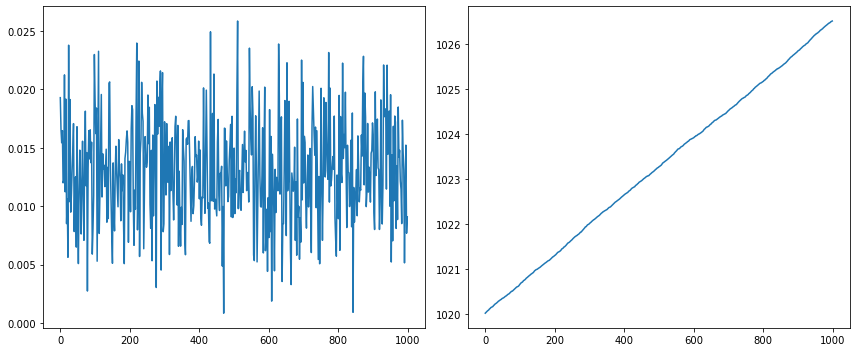

In [120]:
plt.figure(figsize= (12, 5))
plt.subplot(121)
plt.plot(z, N2)

plt.subplot(122)
plt.plot(z, rho)

plt.tight_layout()

In [121]:
T, _ = gsw.CT_from_rho(rho, S, 0)

spice = gsw.spiciness0(S, T)

In [122]:
profile = xr.Dataset(data_vars=dict(
                        CT=(['depth'],T),
                        SA=(['depth'],S),
                        SIG=(['depth'],rho),
                        SPICE=(['depth'], spice)
                        ),
                    coords=dict(
                        depth=z,)
                        )

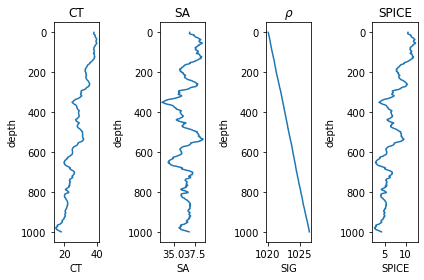

In [123]:
plt.subplot(141)
profile.CT.plot(y='depth')
plt.gca().invert_yaxis()
plt.title('CT')

plt.subplot(142)
profile.SA.plot(y='depth')
plt.gca().invert_yaxis()
plt.title('SA')

plt.subplot(143)
profile.SIG.plot(y='depth')
plt.gca().invert_yaxis()
plt.title(r'$\rho$')

plt.subplot(144)
profile.SPICE.plot(y='depth')
plt.gca().invert_yaxis()
plt.title('SPICE')


plt.tight_layout()

### Boundaries

A few different approaches are possible here, a few of them are noted below:
- filter the whole profile
- filter the whole profile, then mask both boundaries (based on the filter scale)
- filter the whole profile, then mask the upper boundary (based on the mixed layer depth)
- select the profile below the mixed layer, then filter

First up, I'll need to get a handle on mixed layer datasets. Looking at the netcdf file with MLD for every argo profile here: http://mixedlayer.ucsd.edu/. It's a large file though (300+MB) so I have to figure out the best way to upload it here.

In [157]:
CT_filt_whole = ff.get_filt_prof(profile.CT,                                                     100,dim2='depth')
CT_filt_part  = ff.get_filt_prof(profile.CT.where(profile.depth>=100).where(profile.depth<=900), 100,dim2='depth')

In [158]:
filt = xr.Dataset(data_vars=dict(
                        CT       = (['depth'], T),
                        SA       = (['depth'], S),
                        SIG      = (['depth'], rho),
                        SPICE    = (['depth'], spice),
                        CT_whole = (['depth'], CT_filt_whole),
                        CT_part  = (['depth'], CT_filt_part)),
                    coords=dict(
                        depth=z,)
                        )

In [159]:
filt = filt.assign(CT_whole_mask = filt.CT_whole.where(profile.depth>=100).where(profile.depth<=900))
filt = filt.assign(CT_part_mask  = filt.CT_part.where (profile.depth>=200).where(profile.depth<=800))

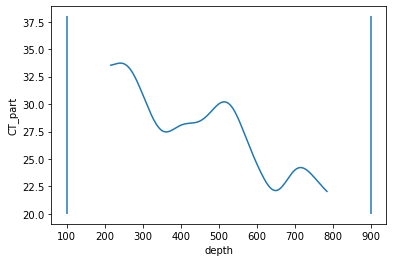

In [156]:
filt.CT_part.where(filt.depth>=100).where(filt.depth<=900).plot()
plt.vlines((100,900),20,38)

Text(0.5, 1.0, 'Filtered CT Profiles')

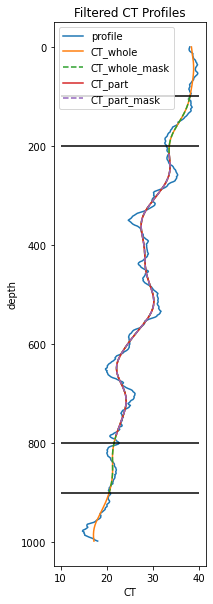

In [160]:
plt.figure(figsize=(6,10))
plt.subplot(122)
profile.CT.plot(y='depth',label='profile')

filt.CT_whole.plot(y='depth',label='CT_whole')
filt.CT_whole_mask.plot(y='depth',label='CT_whole_mask',linestyle='--')
plt.hlines([100,900],10,40,color='k')

filt.CT_part.plot(y='depth',label='CT_part')
filt.CT_part_mask.plot(y='depth',label='CT_part_mask',linestyle='--')
plt.hlines([200,800],10,40,color='k')

plt.gca().invert_yaxis()
plt.xlabel('CT')
plt.legend()
plt.title('Filtered CT Profiles')

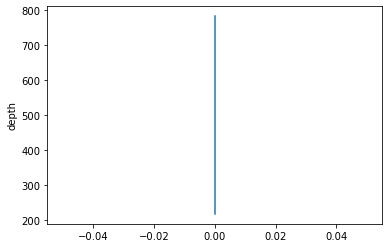

In [12]:
(filt.CT_whole - filt.CT_part).plot(y='depth')

This is strange. Proving the filter with a different profile (or in this case a different section of the same profile) should return a different filtered signal, right? Also, CT_part should be from depth (100,900) but it looks like closer to (200,800). Additionally, part_mask should be from depth (200,800), but it's not exactly on those lines.

All told, there's a lot to look at here, and I feel like I'm getting no where. Time to move on and circle back with a fresh mind.

### Spice Anomaly

Want to compare Dhruv's method (computing spice based on glider reference temperature) to my method (using the defaults in gsw, then calculating the anomaly). Does removing the mean impact the other metrics we are looking at?

In [3]:
float_z = xr.open_dataset('202206_floats/float_ID:(1901700)_ds_z.nc')
float_r = xr.open_dataset('202206_floats/float_ID:(1901700)_ds_rho.nc')

In [161]:
float_z

<xarray.Dataset>
Dimensions:                (N_PROF: 109, PRES_INTERPOLATED: 1000)
Coordinates:
  * N_PROF                 (N_PROF) int64 5 6 8 10 11 12 ... 112 113 114 115 116
    TIME                   (N_PROF) datetime64[ns] ...
    LATITUDE               (N_PROF) float64 ...
    LONGITUDE              (N_PROF) float64 ...
  * PRES_INTERPOLATED      (PRES_INTERPOLATED) int64 0 2 4 6 ... 1994 1996 1998
    N_PROF_NEW             (N_PROF) int64 ...
Data variables:
    CONFIG_MISSION_NUMBER  (N_PROF) int32 ...
    CT                     (N_PROF, PRES_INTERPOLATED) float64 ...
    CYCLE_NUMBER           (N_PROF) int32 ...
    DATA_MODE              (N_PROF) object ...
    DIRECTION              (N_PROF) object ...
    PLATFORM_NUMBER        (N_PROF) int32 ...
    PRES                   (N_PROF, PRES_INTERPOLATED) float64 ...
    PSAL                   (N_PROF, PRES_INTERPOLATED) float64 ...
    SA                     (N_PROF, PRES_INTERPOLATED) float64 ...
    SIG0                   (N_PROF, PRES_INTERPOLATED) float64 ...
    TEMP                   (N_PROF, PRES_INTERPOLATED) float64 ...
    SPICE                  (N_PROF, PRES_INTERPOLATED) float64 ...
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         /swot/SUM05/dbalwada/Argo_sync
    Fetched_by:           amf2288
    Fetched_date:         2023/06/01
    Fetched_constraints:  phy;WMO1901700
    Fetched_uri:          
    history:              Variables filtered according to DATA_MODE; Variable...

In [90]:
n=0
mean_prof  = float_r.SPICE.isel(rho_grid=n).mean(skipna=True)
spice_prof = float_r.SPICE.isel(rho_grid=n) - mean_prof

for n in range(1,len(float_r.rho_grid)):
    mean_prof       = float_r.SPICE.isel(rho_grid=n).mean(skipna=True)
    spice_prof_next = float_r.SPICE.isel(rho_grid=n) - mean_prof

    spice_prof = xr.concat([spice_prof, spice_prof_next], dim='rho_grid')

In [88]:
alpha = gsw.alpha(float_r.SA, float_r.CT, float_r.PRES_INTERPOLATED)

dCT = float_r.CT - float_r.CT.mean('N_PROF_NEW')
float_r['spice']= 2*1000*alpha*dCT

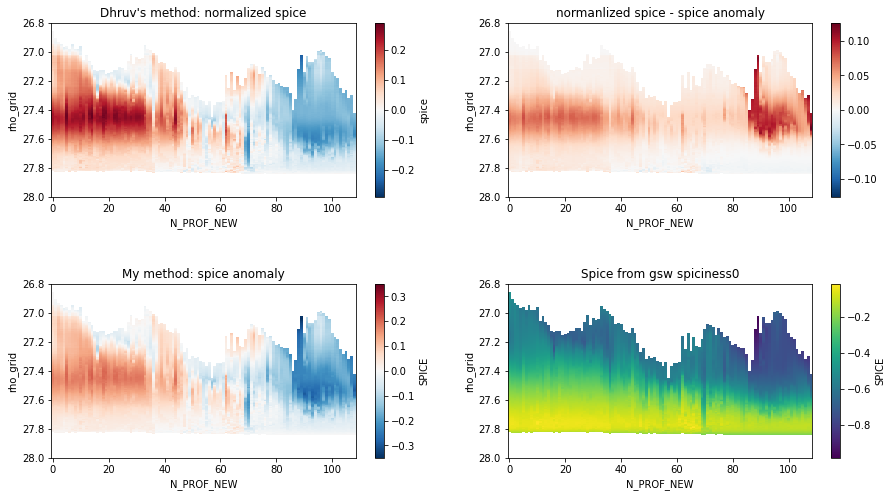

In [91]:
plt.figure(figsize=(15,8))

plt.subplot(2,2,1)
float_r.spice.plot()
plt.gca().invert_yaxis()
plt.title("Dhruv's method: normalized spice")

plt.subplot(2,2,2)
(float_r.spice - spice_prof).plot()
plt.gca().invert_yaxis()
plt.title("normanlized spice - spice anomaly")

plt.subplot(2,2,3)
spice_prof.plot()
plt.gca().invert_yaxis()
plt.title("My method: spice anomaly")

plt.subplot(2,2,4)
float_r.SPICE.plot()
plt.gca().invert_yaxis()
plt.title("Spice from gsw spiciness0")

plt.subplots_adjust(hspace=0.5)

The plots above visually compare the two different methods to calculate spice/spice anomly. It seems like the next step would be to calculate variance of spice/spice anomaly and see what the differences between these are (since this is one option for a comparison metric).

# Dynamic Depth Warping (DDW)

In [4]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import seaborn as sbn
import matplotlib as mpl

In [5]:
def compute_euclidean_distance_matrix(x, y) -> np.array:
    """Calculate distance matrix
    This method calcualtes the pairwise Euclidean distance between two sequences.
    The sequences can have different lengths.
    """
    dist = np.zeros((len(y), len(x)))
    for i in range(len(y)):
        for j in range(len(x)):
            dist[i,j] = (x[j]-y[i])**2
    return dist

In [6]:
def compute_accumulated_cost_matrix(x, y) -> np.array:
    """Compute accumulated cost matrix for warp path using Euclidean distance
    """
    distances = compute_euclidean_distance_matrix(x, y)

    # Initialization
    cost = np.zeros((len(y), len(x)))
    cost[0,0] = distances[0,0]
    
    for i in range(1, len(y)):
        cost[i, 0] = distances[i, 0] + cost[i-1, 0]  
        
    for j in range(1, len(x)):
        cost[0, j] = distances[0, j] + cost[0, j-1]  

    # Accumulated warp path cost
    for i in range(1, len(y)):
        for j in range(1, len(x)):
            cost[i, j] = min(
                cost[i-1, j],    # insertion
                cost[i, j-1],    # deletion
                cost[i-1, j-1]   # match
            ) + distances[i, j] 
            
    return cost

In [7]:
CT_bar = float_z.CT.mean('N_PROF')
SA_bar = float_z.SA.mean('N_PROF')
SIG0_bar = float_z.SIG0.mean('N_PROF')

In [21]:
num = 100

CT_sample = float_z.CT.isel(N_PROF=num)
SA_sample = float_z.SA.isel(N_PROF=num)
SIG0_sample = float_z.SIG0.isel(N_PROF=num)

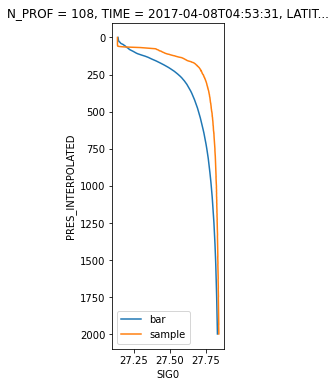

In [22]:
plt.figure(figsize=(2,6))
SIG0_bar.plot(y='PRES_INTERPOLATED', label='bar')
SIG0_sample.plot(y='PRES_INTERPOLATED', label='sample')
plt.gca().invert_yaxis()
plt.legend()

In [23]:
SIG0_matrix = compute_accumulated_cost_matrix(SIG0_bar.values, SIG0_sample.values)

In [64]:
dtw_distance, warp_path = fastdtw(SIG0_bar.values, SIG0_sample.values, radius=1000, dist=euclidean)

In [65]:
SIG0_matrix.shape

(1000, 1000)

In [66]:
# Get the warp path in x and y directions
path_x = [p[0] for p in warp_path]
path_y = [p[1] for p in warp_path]

# Align the path from the center of each cell
path_xx = [x+0.5 for x in path_x]
path_yy = [y+0.5 for y in path_y]

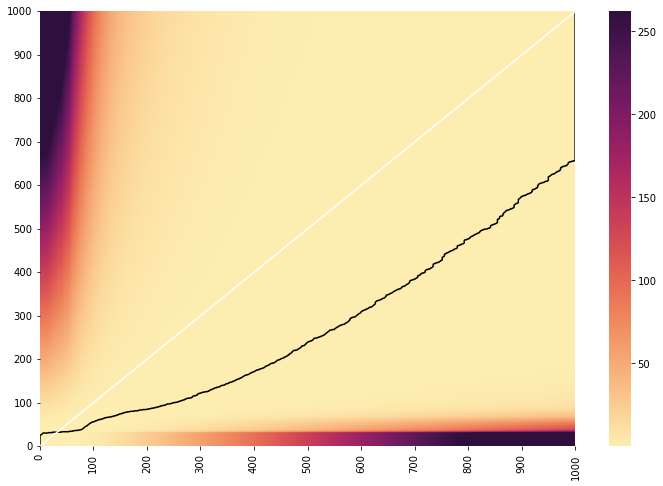

In [68]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = sbn.heatmap(SIG0_matrix, cmap=cmo.matter, ax=ax, robust=True)
ax.invert_yaxis()

ax.plot(path_xx, path_yy, color='black', linewidth=1.5)
ax.plot([0,1000], [0,1000], color='white', linewidth=1.5)

plt.xticks(range(0,1001,100),range(0,1001,100))
plt.yticks(range(0,1001,100),range(0,1001,100));

#fig.savefig("ex1_heatmap.png", **savefig_options)

A few observations:
- This path deviates pretty significantly from the 1:1 line. [[Chung 2019]] suggested that applying a penalty to keep the warping path from straying too far from the 1:1 line helps with noisy data. How is this actually implemented?
- The biggest question for me is how is this warping path converted to depth offset/heave because it has a different shape.
- Also, I'm a bit worried about the accuracy of this plot because visually the profiles look pretty similar at depth, with the biggest changes between 100m and 1200m. Here, it seems like there's more of a permenant "divergence." I'm wondering if the penalty [[Chung 2019]] suggested could improve this

Another note: I think the best way to tackle this conversion from warp path to depth coordinates is create synthetic sample and reference profiles with a known amount of offset between them, run them through the methods above, and see if we can somehow recover something close to the offset we put in.